# SAM pipeline

### Although our main experiments use Grounded SAM with class-conditional prompts, this section provides an implementation using standard SAM, which does not require human input 

In [76]:
# Enable it for DEMO
import warnings
warnings.filterwarnings("ignore")

## Resnet-18 Fine-Tuning

In [77]:
from torchvision import datasets, models
from torch import nn, optim
import os 

if not os.path.exists("/kaggle/input/pre-computations/best_model.pth"):
    # Load pre-trained ResNet-18
    model = models.resnet18(pretrained=True)
    
    # Replace the final layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cats and dogs
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    epochs = 20
    best_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
    
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
    
        epoch_loss = running_loss / len(train_dataloader)
        train_accuracy = correct / len(train_dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
        # Evaluation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        test_accuracy = correct / total
        print(f"Test Accuracy: {test_accuracy:.4f}")
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), "best_model.pth")
    

# Medoid

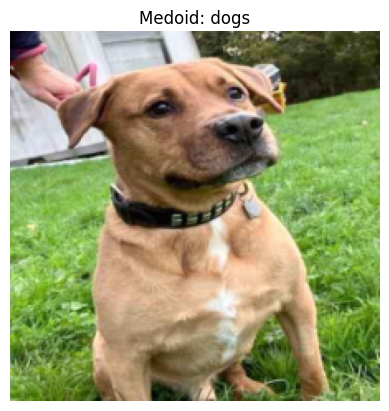

In [78]:
import torch
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder("/kaggle/input/cats-and-dogs-image-classification/test", transform=transform)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model (feature extractor)
model_medoid = models.resnet50(pretrained=True)
model_medoid.fc = torch.nn.Identity()  # rimuove l'ultimo strato per ottenere feature
model_medoid = model_medoid.to(device).eval()

# Pick one image
model_medoid.eval()

class_names = test_dataset.classes
medoid_class = "dog"

if medoid_class == "cat":
    target_class = 0
else:
    target_class = 1


idxs = [i for i, (_, label) in enumerate(test_dataset) if label == target_class]
subset = Subset(test_dataset, idxs)
loader = DataLoader(subset, batch_size=32, shuffle=False)

features = []
images = []

with torch.no_grad():
    for x, _ in loader:
        x = x.to(device)
        feats = model_medoid(x).cpu().numpy()
        features.append(feats)
        images.append(x.cpu())

features = np.concatenate(features, axis=0)
images = torch.cat(images, dim=0)
dists = pairwise_distances(features, metric='euclidean')
mean_dists = dists.mean(axis=1)
medoid_idx = np.argmin(mean_dists)
unnormalize = T.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])],
                          std=[1/s for s in [0.229, 0.224, 0.225]])

medoid_img = unnormalize(images[medoid_idx]).permute(1, 2, 0).numpy()
medoid_img = np.clip(medoid_img, 0, 1)

plt.imshow(medoid_img)
plt.axis("off")
plt.title(f"Medoid: {class_names[target_class]}")
plt.show()

# Instance to explain

In [79]:
IMAGE_PATH="/kaggle/input/cats-and-dogs-image-classification/test/cats/cat_106.jpg"

In [80]:
!pip install captum

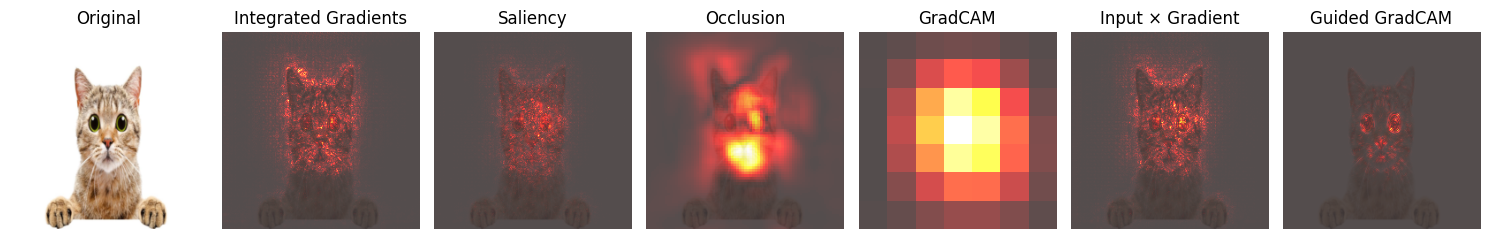

In [81]:
from captum.attr import IntegratedGradients, Saliency, Occlusion, LayerGradCam, InputXGradient, GuidedBackprop
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Model setup
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("/kaggle/input/pre-computations/best_model.pth"))
model = model.to(device).eval()

# 2. Prepare image
image_paths = [path for path, _ in test_dataset.samples]
image_idx = next(i for i, path in enumerate(image_paths) if os.path.normpath(IMAGE_PATH) == os.path.normpath(path))
image, _ = test_dataset[image_idx]  # tipo: [3, 224, 224]
input_tensor = image.unsqueeze(0).to(device)

# 3. Inference
with torch.no_grad():
    pred = model(input_tensor)
target_class = pred.argmax(dim=1).item()
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone().detach().cpu().numpy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img.transpose(1, 2, 0), 0, 1)

orig_np = unnormalize(image, mean, std)

# Compute GuidedBackprop
guided_bp = GuidedBackprop(model).attribute(input_tensor, target=target_class)

# Compute GradCAM
gradcam_layer = model.layer4[-1]
layer_gc = LayerGradCam(model, gradcam_layer).attribute(input_tensor, target=target_class)

# Upsample GradCAM map to input size
layer_gc_upsampled = torch.nn.functional.interpolate(
    layer_gc, size=(224, 224), mode='bilinear', align_corners=False
)

# Multiply element-wise (Guided GradCAM)
guided_gradcam = guided_bp * layer_gc_upsampled

methods = {
    "Integrated Gradients": IntegratedGradients(model).attribute(input_tensor, target=target_class, n_steps=200),
    "Saliency": Saliency(model).attribute(input_tensor, target=target_class),
    "Occlusion": Occlusion(model).attribute(
        input_tensor, strides=(1, 3, 3), target=target_class,
        sliding_window_shapes=(1, 15, 15), baselines=0),
    "GradCAM": layer_gc,
    "Input × Gradient": InputXGradient(model).attribute(input_tensor, target=target_class),
    "Guided GradCAM": guided_gradcam
}

# 6. Visualize
fig, axs = plt.subplots(1, len(methods) + 1, figsize=(15, 5))
axs[0].imshow(orig_np)
axs[0].set_title("Original")
axs[0].axis("off")

attributions_gray = {}

for i, (name, attr) in enumerate(methods.items(), start=1):
    attr_np = attr.squeeze().detach().cpu().numpy()
    if attr_np.ndim == 3:
        attr_gray = np.sum(np.abs(attr_np), axis=0)
    else:
        attr_gray = np.abs(attr_np)
    attr_vis = (attr_gray - attr_gray.min()) / (attr_gray.max() - attr_gray.min() + 1e-8)
    
    attributions_gray[name] = attr_gray  # Save for metrics

    axs[i].imshow(orig_np, alpha=0.3)
    axs[i].imshow(attr_vis, cmap="hot", alpha=0.7)
    axs[i].set_title(name)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Segmentation Model (SAM example)
In order to remove meaningful patches of the input, we adopted the SAM and Grounded-SAM. The former segments everything, while the latter segnments just the parts requested by prompt. The advantage of SAM is that do not require human intervention for the attributes provision, but the risk is to have a too low granularity or to not isolate some parts that are meaningful for the decision of the model. Using Grounded-SAM instead gives the advantage to decide the granularity of the segmentation, but requires an expert capable to provide the meaningful parts on which a good model should focus on.

In [82]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /kaggle/working


In [83]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [84]:
!pip install -q supervision==0.23.0

In [85]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

/kaggle/working/weights/sam_vit_h_4b8939.pth ; exist: True


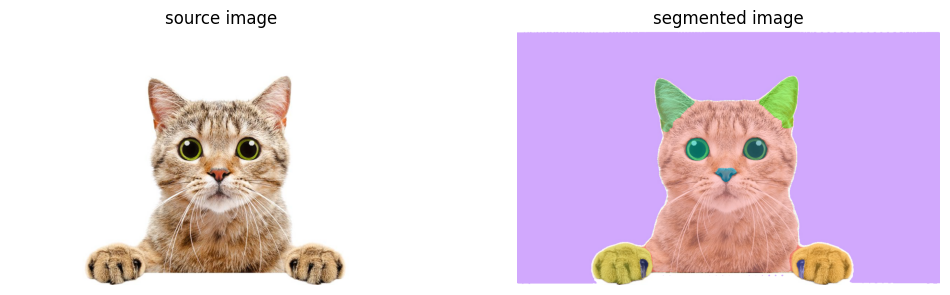

In [86]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"



sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)


import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [87]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area']) #, reverse=True
]

# Check mask removal

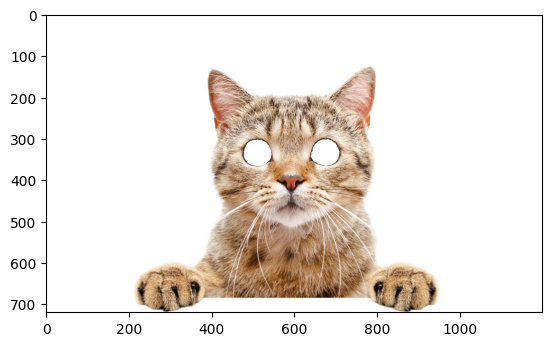

In [88]:
mask_to_remove = masks[5]
image_removed = image_rgb.copy()
image_removed[mask_to_remove] = 255  # white out that area
plt.imshow(image_removed)

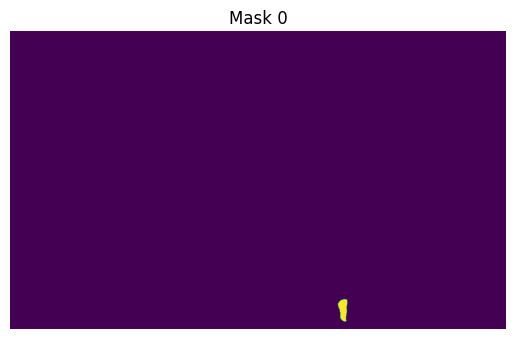

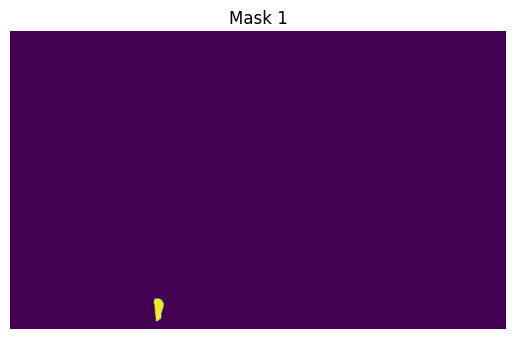

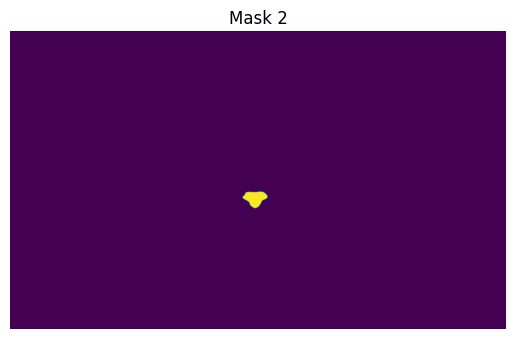

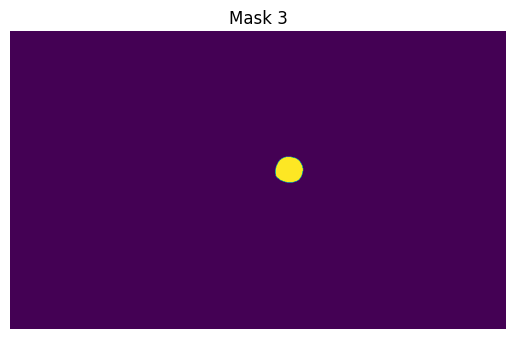

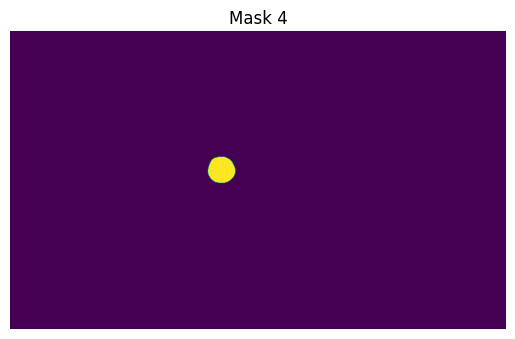

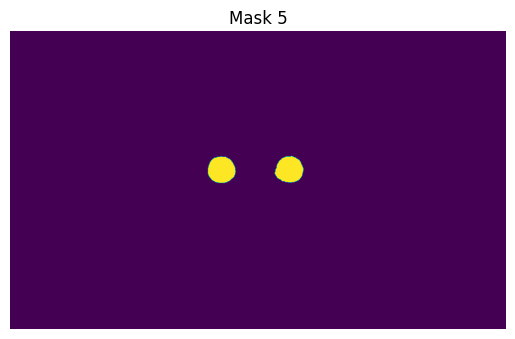

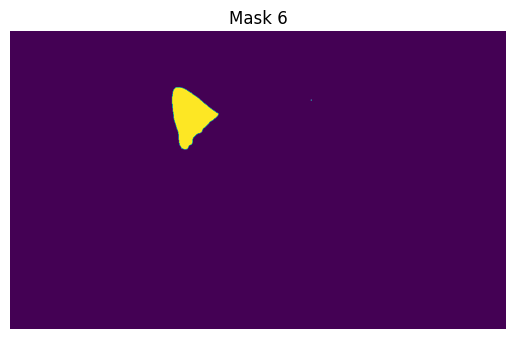

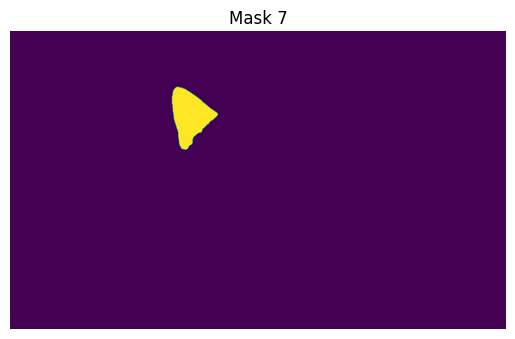

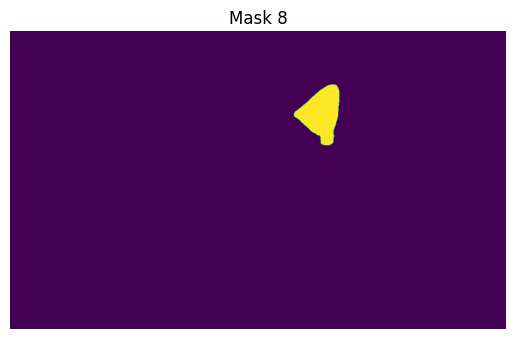

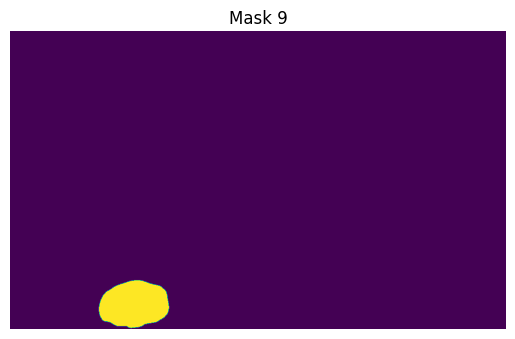

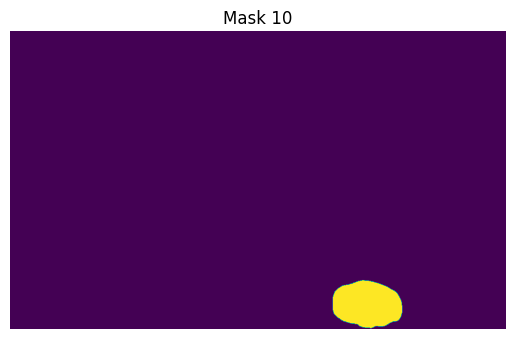

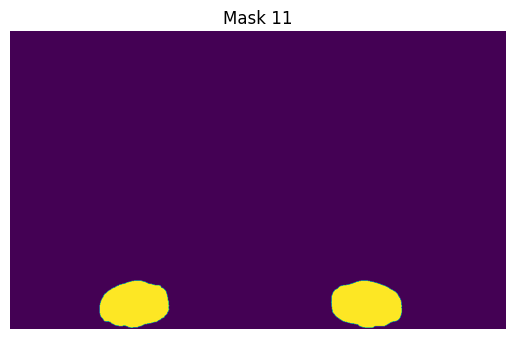

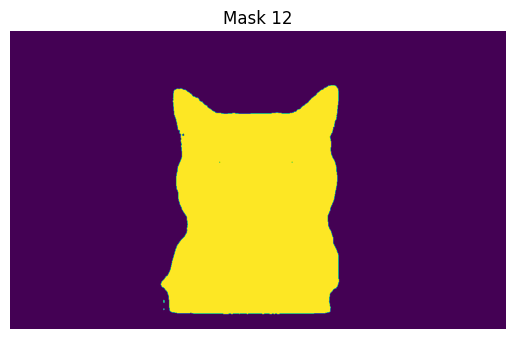

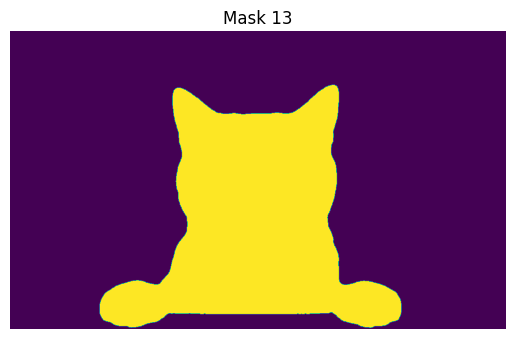

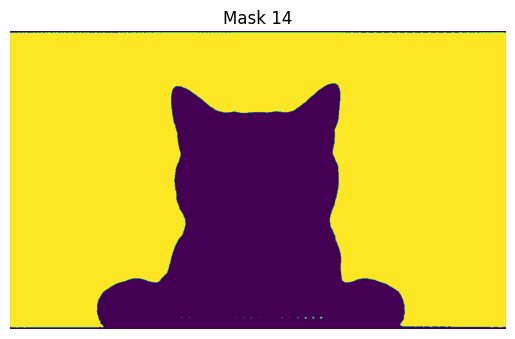

In [89]:
from matplotlib import pyplot as plt
for i, mask in enumerate(masks):
    plt.imshow(mask)
    plt.title(f"Mask {i}")
    plt.axis("off")
    plt.show()

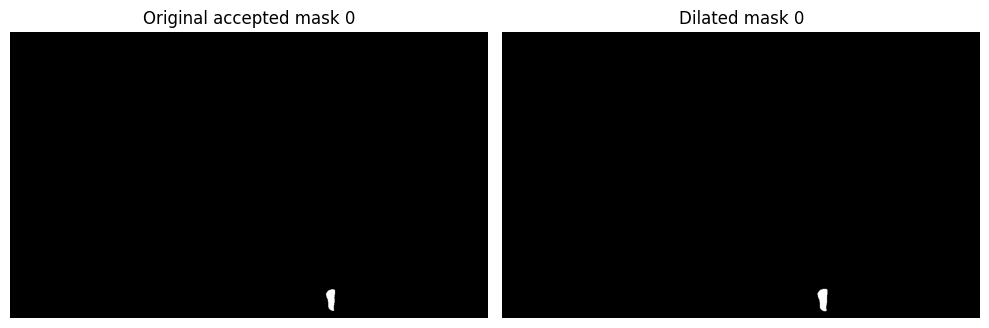

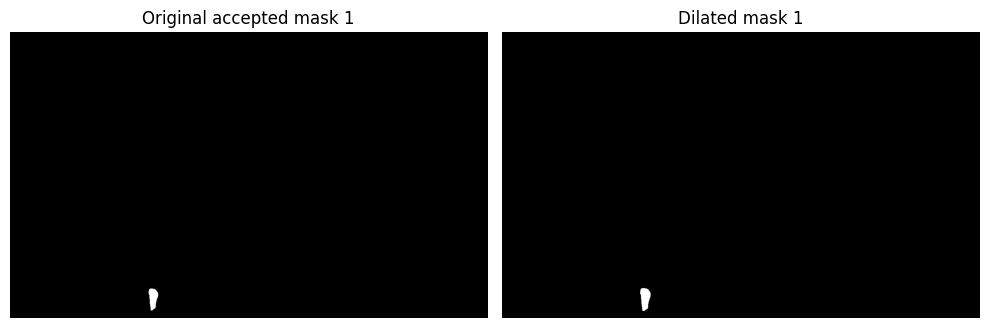

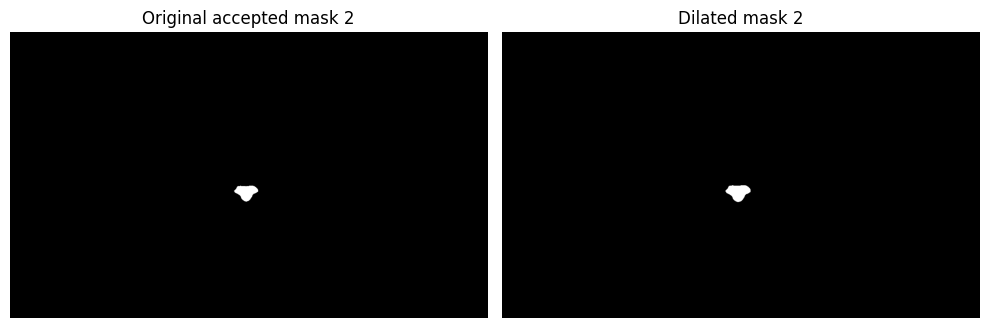

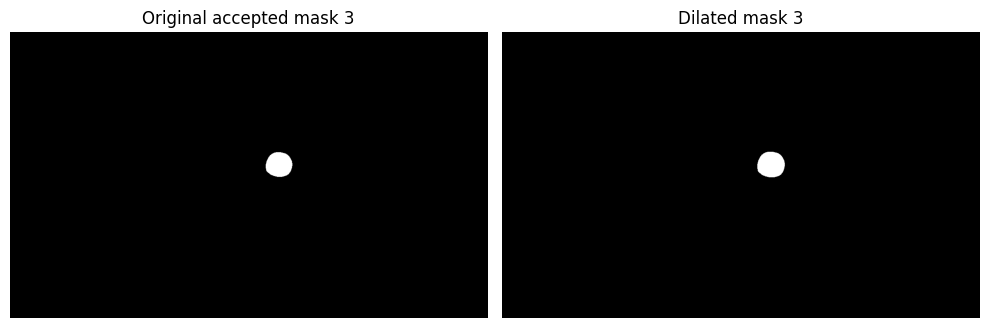

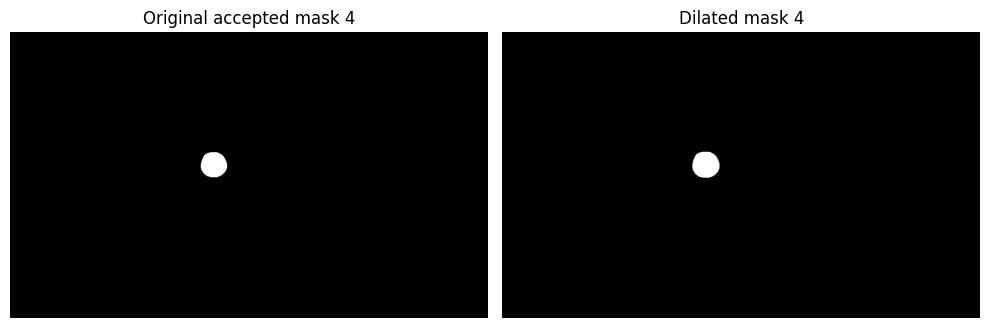

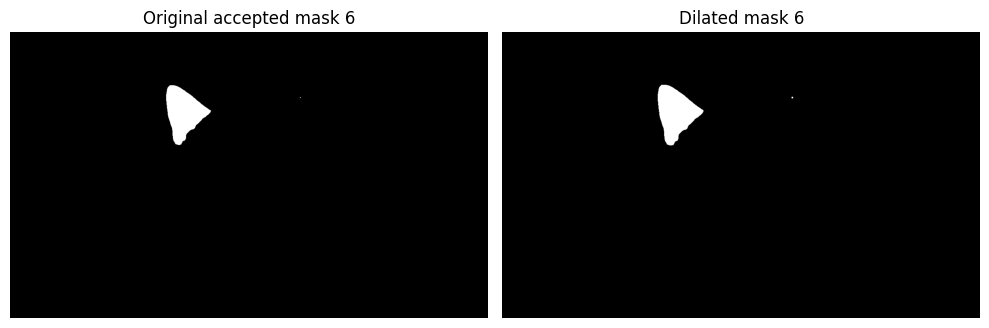

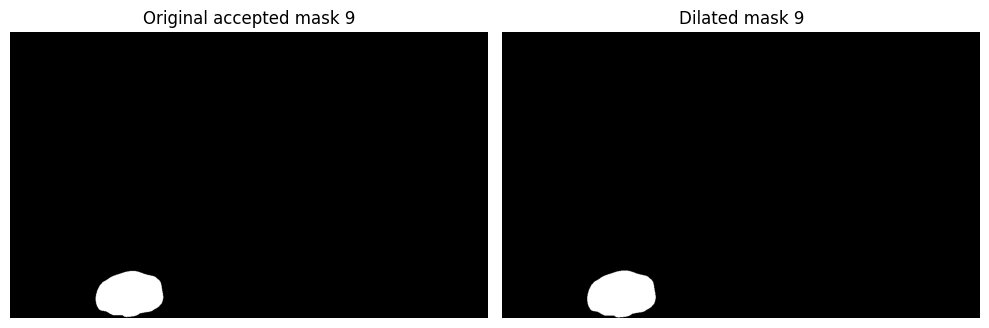

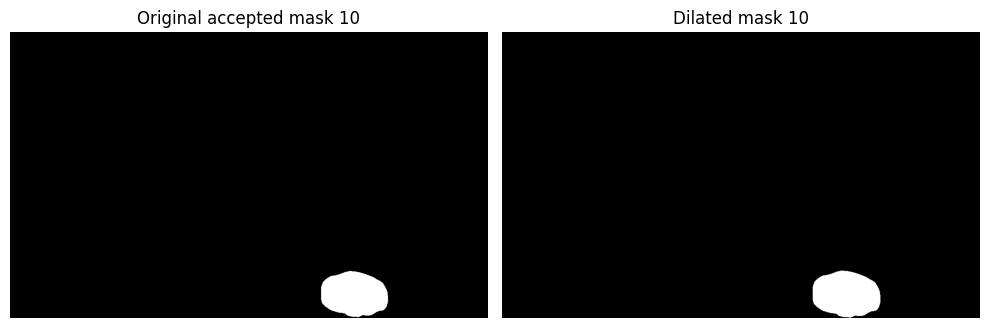

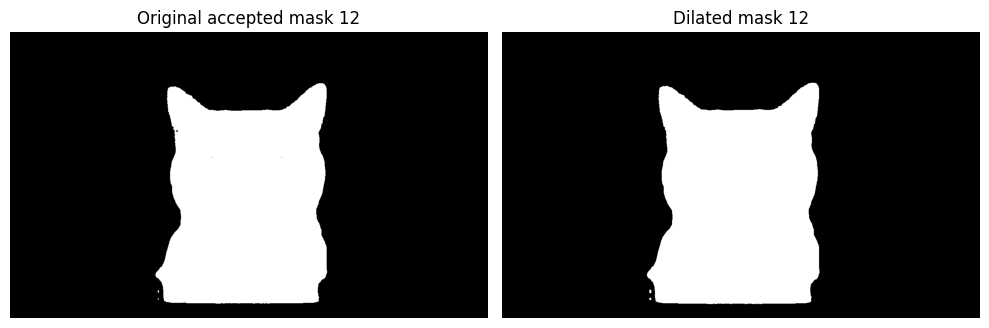

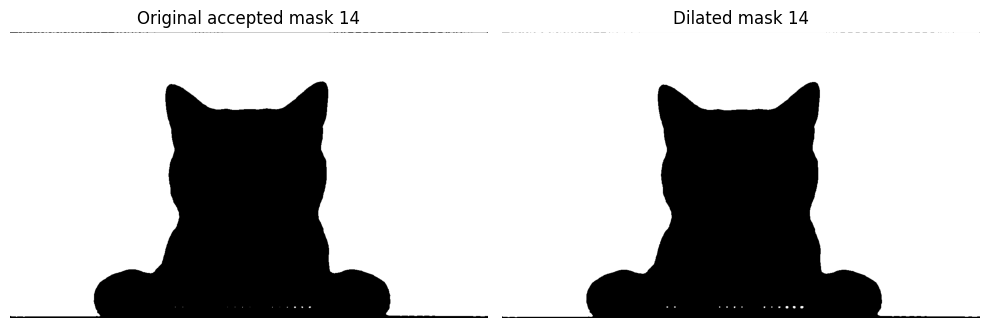

In [90]:
# 1. Initialize combined mask
H, W = masks[0].shape
combined_mask = np.zeros((H, W), dtype=bool)

# Parametri
tolerance = 0.5
accepted_masks = []
dilated_masks = []

# Loop on masks
for i, mask in enumerate(masks):
    overlap = np.logical_and(combined_mask, mask)
    overlap_area = overlap.sum()
    mask_area = mask.sum()

    # Condizione di accettazione per overlap
    if mask_area == 0 or (overlap_area / mask_area) <= tolerance:
        accepted_masks.append(mask)
        combined_mask |= mask  

        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1).astype(bool)
        dilated_masks.append(dilated_mask)

        # Visualizzazione side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(mask, cmap='gray')
        axs[0].set_title(f"Original accepted mask {i}")
        axs[0].axis("off")
        axs[1].imshow(dilated_mask, cmap='gray')
        axs[1].set_title(f"Dilated mask {i}")
        axs[1].axis("off")
        plt.tight_layout()
        plt.show()

H, W = dilated_masks[0].shape
total_accepted = np.zeros((H, W), dtype=bool)
for mask in dilated_masks:
    total_accepted |= mask

uncovered_mask = ~total_accepted
dilated_masks.append(uncovered_mask)

# Rank masks

In [91]:
import cv2

# First, prepare the IG map
attr_np = attr.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # [224, 224, 3]
attr_gray = np.sum(np.abs(attr_np), axis=-1)  # [224, 224]

# Now score each resized mask
mask_scores = []
for i, mask in enumerate(dilated_masks):
    # Resize mask to 224x224 (ResNet input size)
    resized_mask = cv2.resize(mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)

    mask_area = resized_mask.sum()
    if mask_area == 0:
        score = 0
    else:
        score = attr_gray[resized_mask].sum() / mask_area
    mask_scores.append((i, score))

# Sort by importance
sorted_masks_by_ig = sorted(mask_scores, key=lambda x: x[1], reverse=True)

# Print top scores
print("Top masks by mean IG score:")
for i, score in sorted_masks_by_ig[:5]:
    print(f"Mask {i}: Score = {score:.4f}")


Top masks by mean IG score:
Mask 3: Score = 0.0121
Mask 2: Score = 0.0101
Mask 4: Score = 0.0074
Mask 9: Score = 0.0017
Mask 5: Score = 0.0008


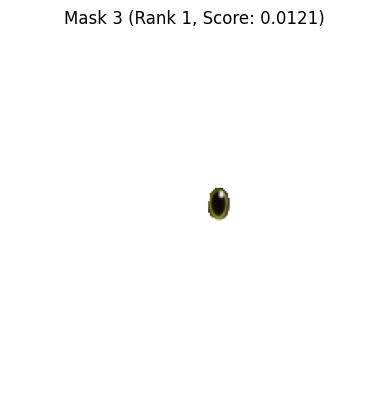

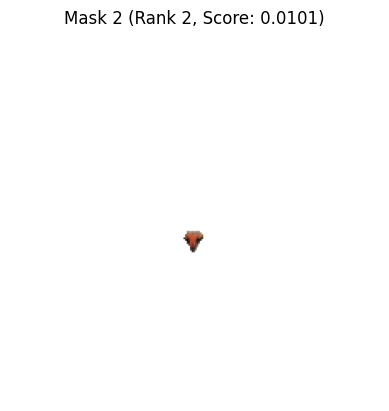

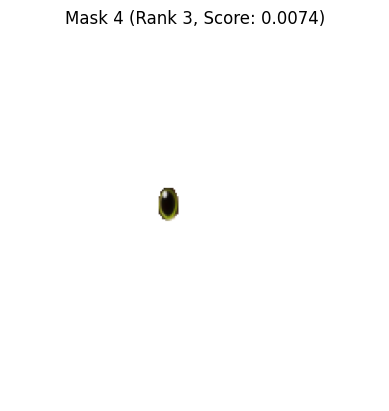

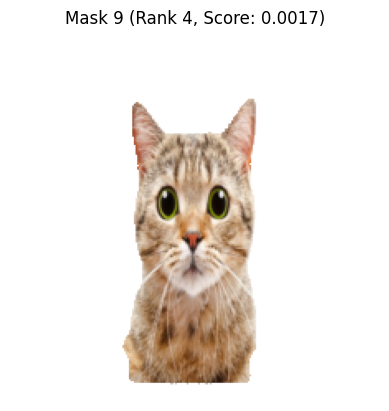

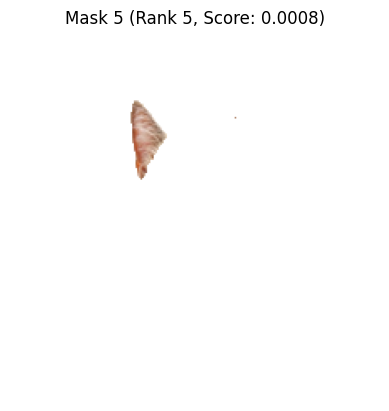

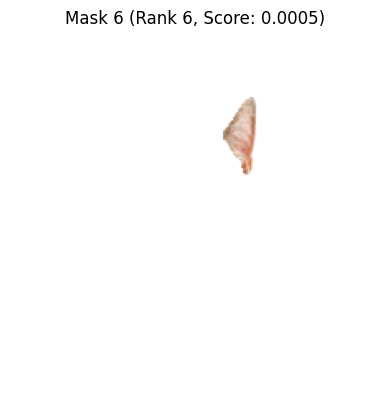

In [92]:
top_k = 6
for rank, (i, score) in enumerate(sorted_masks_by_ig[:top_k]):
    original_mask = dilated_masks[i]  # get the original SAM mask
    resized_mask = cv2.resize(original_mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)

    # Apply the mask to the original image (ResNet input size, already unnormalized)
    masked_image = orig_np.copy()
    masked_image[~resized_mask] = 1.0  # white out everything except the mask

    plt.imshow(masked_image)
    plt.title(f"Mask {i} (Rank {rank+1}, Score: {score:.4f})")
    plt.axis("off")
    plt.show()



# Put the medoid

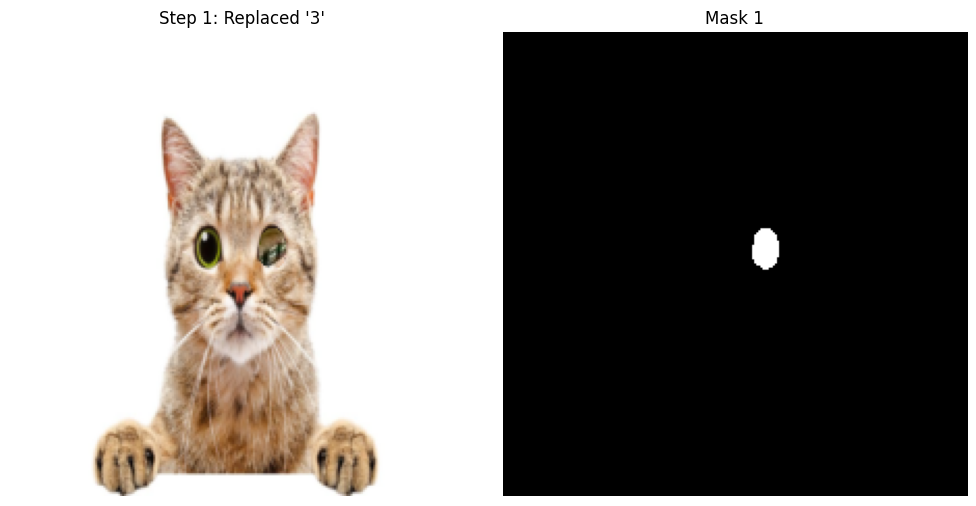

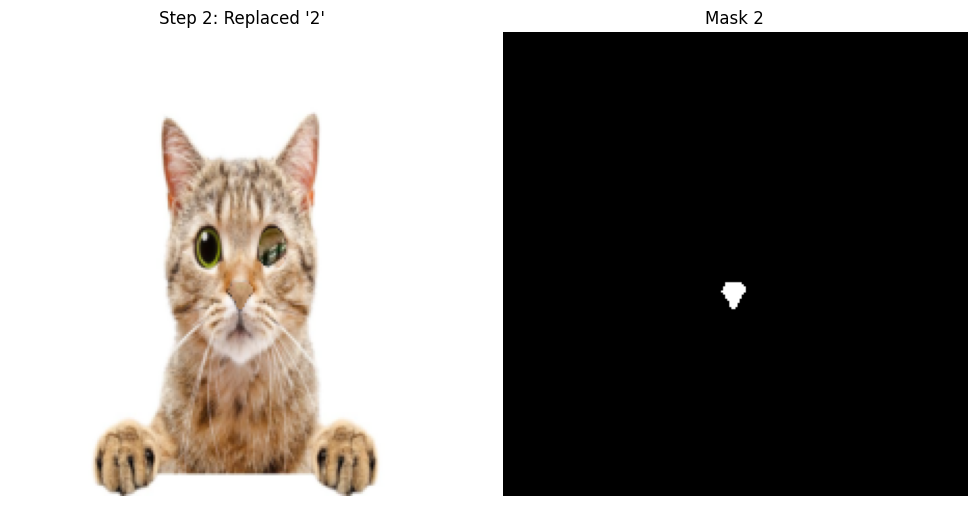

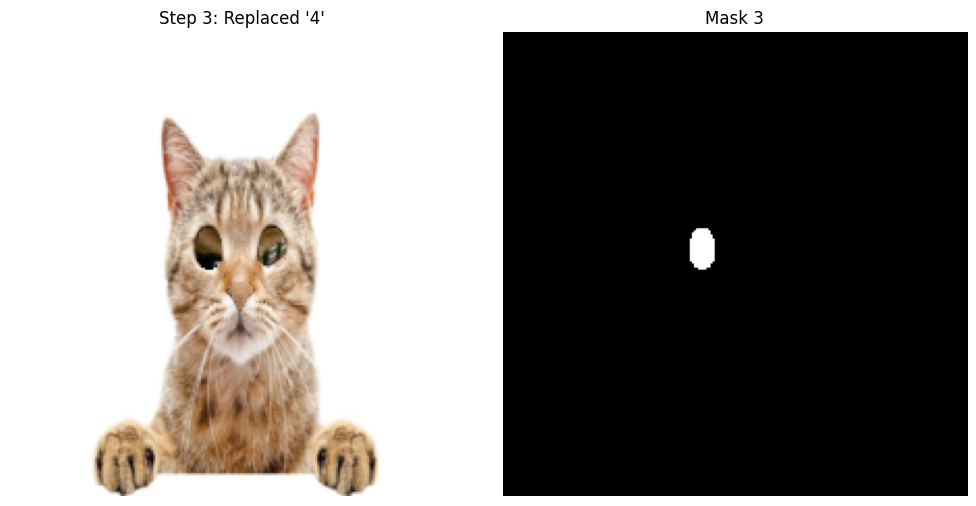

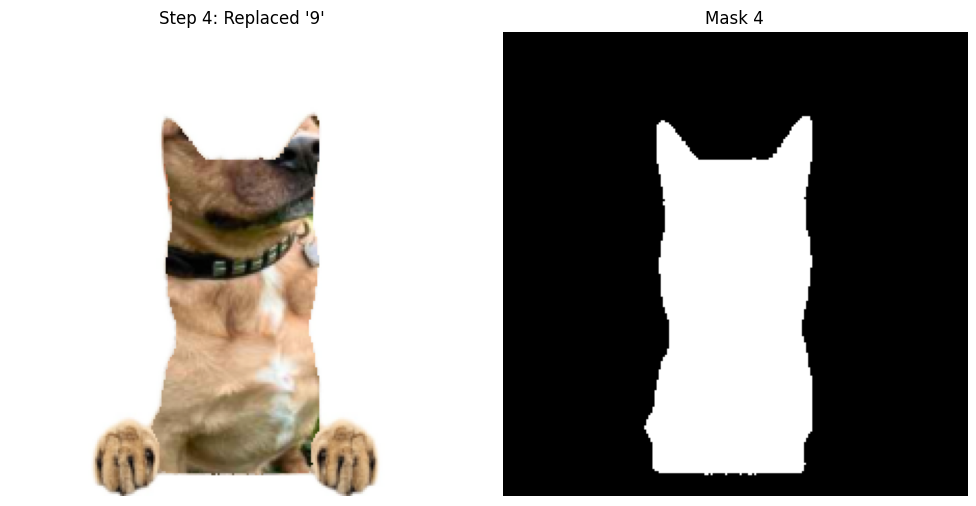

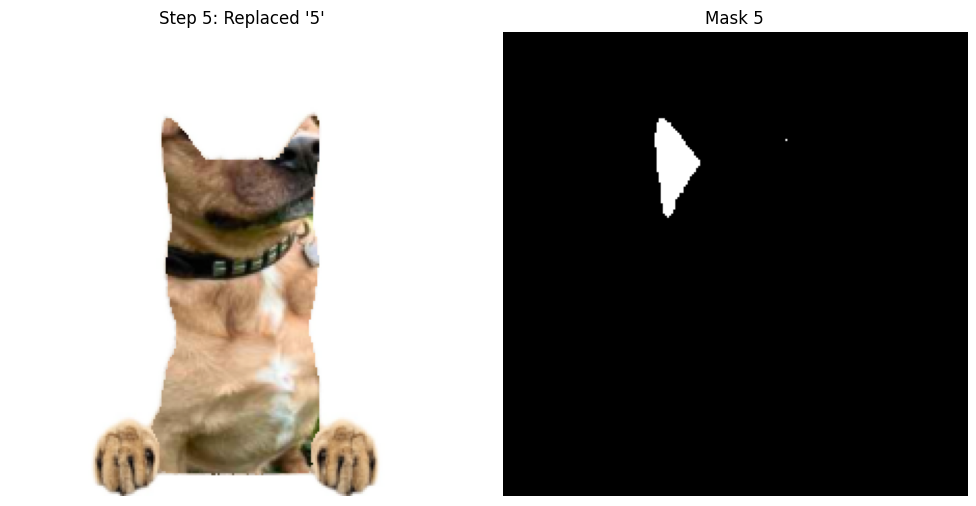

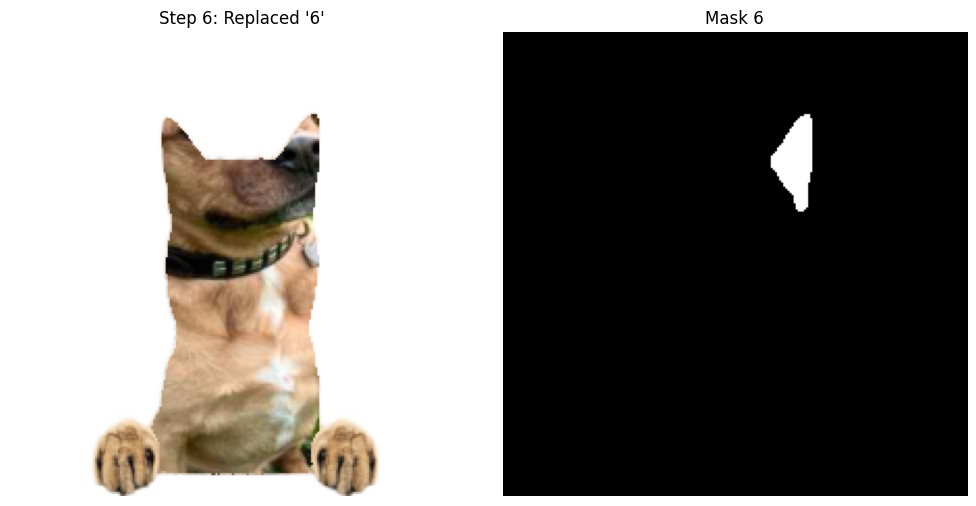

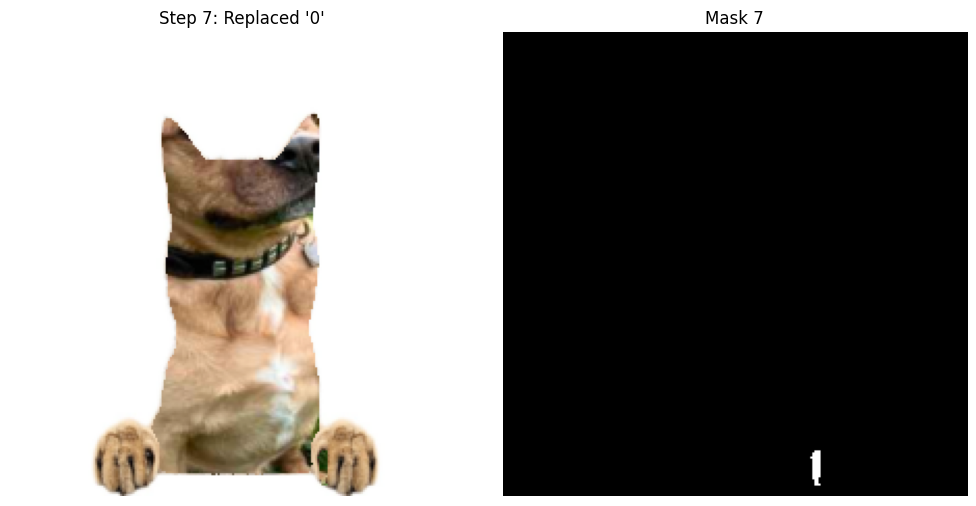

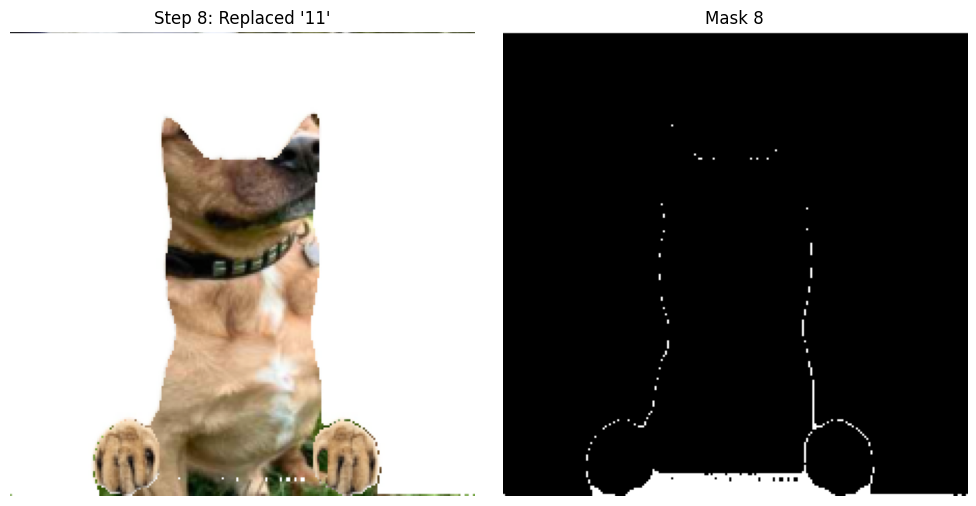

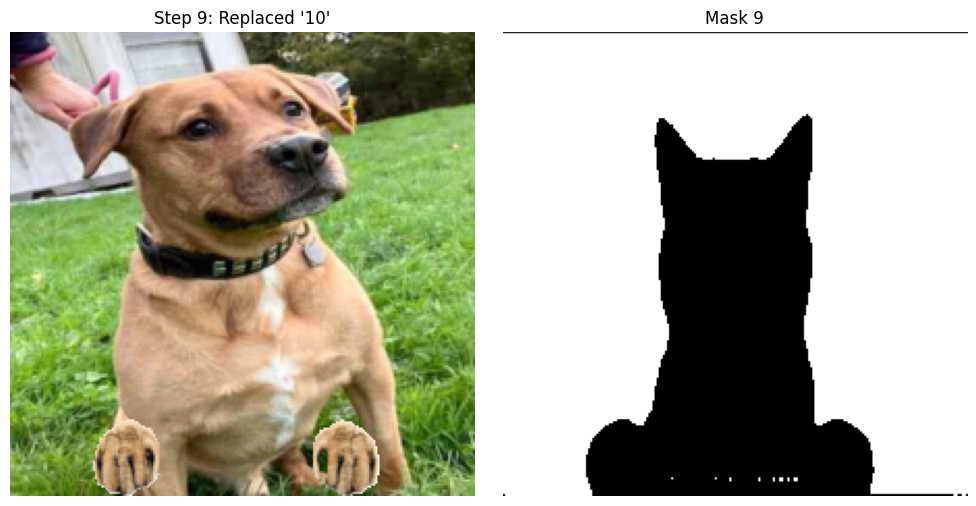

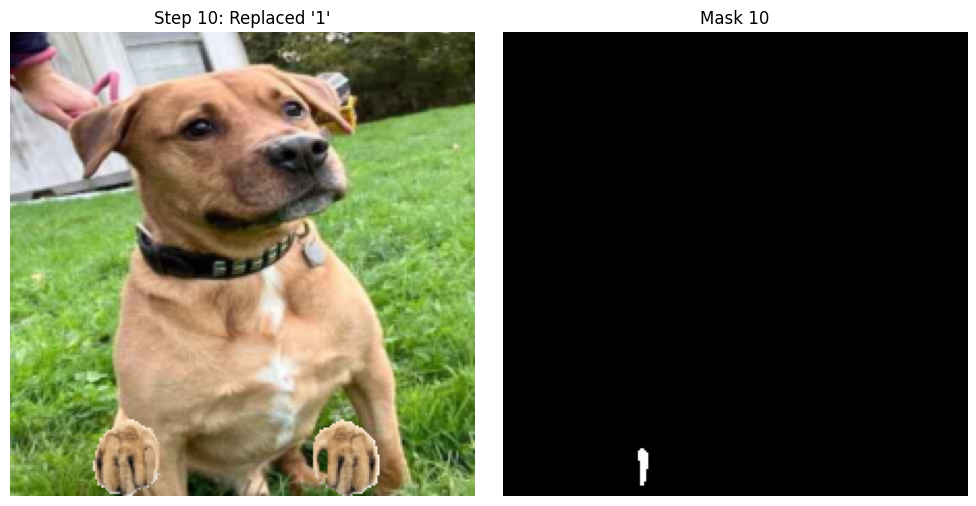

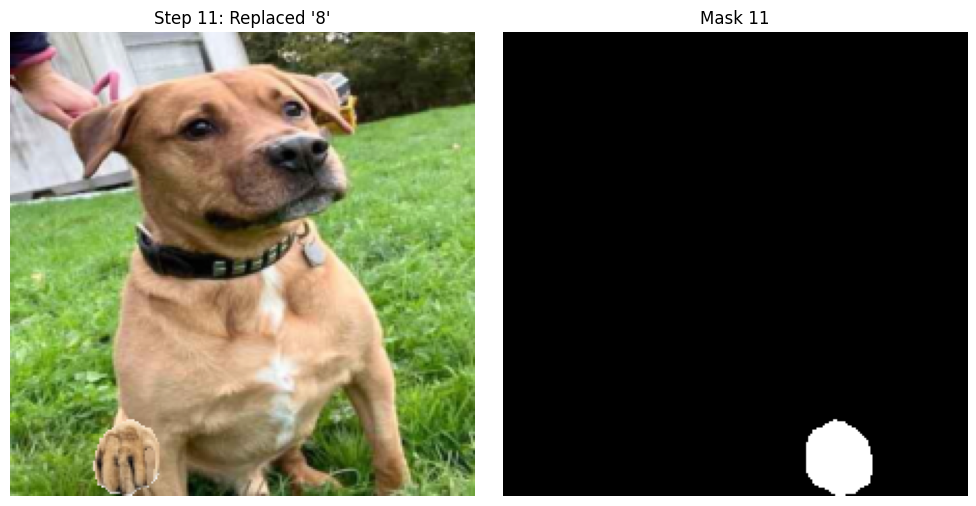

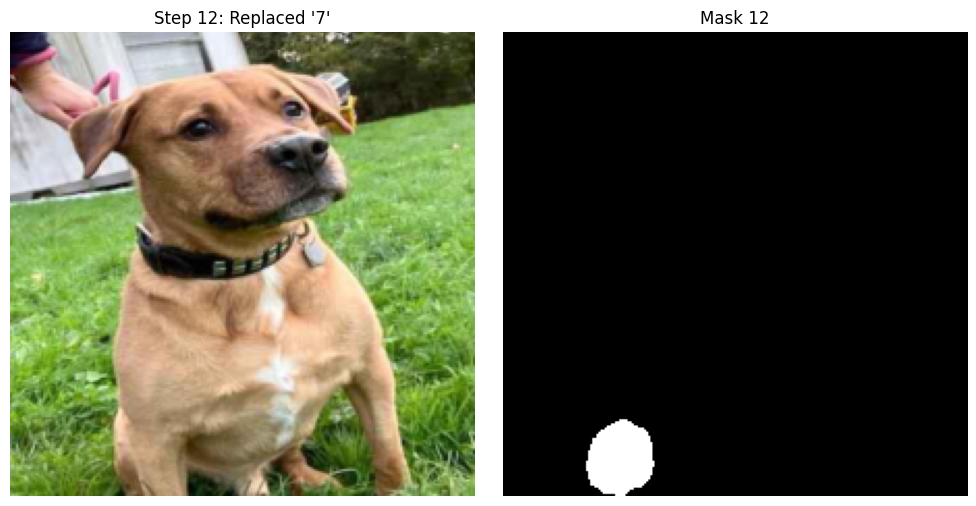

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Deep copy to avoid modifying original
modified_image = orig_np.copy()

# Load and convert medoid
if medoid_class=="cat":
    bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_0.png")
    medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    medoid = medoid.astype(np.float32) / 255.0
else:
    bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_1.png")
    medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    medoid = medoid.astype(np.float32) / 255.0

# Ensure dog_medoid is same shape as modified_image
assert medoid.shape == modified_image.shape, "Shape mismatch between images!"

# Loop through each (mask, label) pair and replace the region
for i, (index, score) in enumerate(sorted_masks_by_ig):
    mask = cv2.resize(dilated_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
     
    mask = mask.astype(bool)  # make sure it's a boolean array

    for c in range(3):  # R, G, B channels
        modified_image[mask, c] = medoid[mask, c]

    # Create a figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Show modified image
    axs[0].imshow(modified_image)
    axs[0].set_title(f"Step {i+1}: Replaced '{index}'")
    axs[0].axis('off')

    # Show corresponding mask
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title(f"Mask {i+1}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    # cv2.imwrite(f"step_{i+1}_{label}.png", cv2.cvtColor(modified_image, cv2.COLOR_RGB2BGR))